In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error


In [3]:
train = pd.read_csv('datasets/train_cleaned.csv', index_col='Id', na_filter=False)
ridge_residuals = pd.read_csv('datasets/ridge_residuals.csv', index_col=0)

In [4]:
ridge_residuals.head()

,SalePrice
Id,
109,41558.229841
544,-286.894447
153,34191.947673
318,-25958.955614
255,-1046.455994


In [5]:
X = train.drop(columns = 'SalePrice')
# y = train['SalePrice']
y = ridge_residuals['SalePrice']

In [6]:
X_test = pd.read_csv('datasets/test_cleaned.csv', index_col = 'Id', na_filter=False)
X_test.head()

,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,is Shed,is PUD,Cond Feeder,Cond Artery,Cond Pos,Cond RR,Porch SF,MoYr Sold,is Remodeled,Last Remodel
Id,,,,,,,,,,,,,,,,,,,,,
2658,RM,69.0000,9142,1,Grvl,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,172,2006.333333,1,56
2718,RL,69.0552,9662,1,None,1,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,170,2006.666667,0,29
2414,RL,58.0000,17104,1,None,1,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,124,2006.750000,0,0
1989,RM,60.0000,8520,1,None,0,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,184,2007.583333,1,1
625,RL,69.0552,9500,1,None,1,Lvl,AllPub,Inside,0,...,0,0,0,0,0,0,261,2009.583333,0,46


In [16]:
X.isna().any().any()

False

### Helper Functions

#### Fit model, score on train, predict, and save outputs

In [7]:
def run_model(model, out, X = X, X_test = X_test):
    model.fit(X, y)
    print(model.score(X, y))
    preds = model.predict(X_test)
    out_df = pd.DataFrame(preds, columns = ['SalePrice'], index = X_test.index)
    out_df.to_csv('submission/' + out + '.csv')

#### Encoder

In [8]:
encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    (OneHotEncoder(), ['Mo Sold', 'Yr Sold', 'MoYr Sold']),
    (StandardScaler(), make_column_selector(dtype_include = [int, float])),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [9]:
pipe_knn = make_pipeline(
    encoder,
    KNeighborsRegressor()
)

In [10]:
pipe_knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder-1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002846D006610>),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(),
                                                  ['Mo Sold', 'Yr Sold',
                                                   'MoYr Sold']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002846D006280>)],
                                   verbose_feature_

In [11]:
params_knn = {
    'kneighborsregressor__n_neighbors': range(2, 50),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2]
}

In [12]:
gs_knn = GridSearchCV(pipe_knn, params_knn, n_jobs = 1, verbose = 2)

In [13]:
knn_log_model = TransformedTargetRegressor(gs_knn, func = np.log, inverse_func= np.exp)

In [14]:
run_model(knn_log_model, 'knn_log')

C:\Users\slitv\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:205: RuntimeWarning: invalid value encountered in log
  return func(X, **(kw_args if kw_args else {}))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
knn_log_model.regressor_.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder-1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4D70929D0>),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(),
                                                  ['Mo Sold', 'Yr Sold',
                                                   'MoYr Sold']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4D7092F40>)],
                                   verbose_feature_

In [ ]:
knn_cv = pd.DataFrame(knn_log_model.regressor_.cv_results_)

In [ ]:
knn_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_kneighborsregressor__n_neighbors',
       'param_kneighborsregressor__p', 'param_kneighborsregressor__weights',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
knn_cv.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsregressor__n_neighbors,param_kneighborsregressor__p,param_kneighborsregressor__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.078821,0.009831,0.107461,0.014935,10,1,distance,"{'kneighborsregressor__n_neighbors': 10, 'knei...",0.812083,0.882409,0.846456,0.798199,0.868368,0.841503,0.032126,1
45,0.077510,0.003177,0.104349,0.009808,13,1,distance,"{'kneighborsregressor__n_neighbors': 13, 'knei...",0.809588,0.880679,0.849293,0.800574,0.866372,0.841301,0.031329,2
41,0.088468,0.014308,0.110461,0.007090,12,1,distance,"{'kneighborsregressor__n_neighbors': 12, 'knei...",0.811026,0.879429,0.849352,0.799148,0.866987,0.841189,0.031214,3
29,0.081486,0.009000,0.099897,0.012899,9,1,distance,"{'kneighborsregressor__n_neighbors': 9, 'kneig...",0.810253,0.883269,0.848757,0.796648,0.864711,0.840728,0.032623,4
37,0.074579,0.003755,0.100300,0.013123,11,1,distance,"{'kneighborsregressor__n_neighbors': 11, 'knei...",0.808813,0.880376,0.848575,0.797797,0.867844,0.840681,0.032343,5
49,0.080051,0.007716,0.098310,0.012074,14,1,distance,"{'kneighborsregressor__n_neighbors': 14, 'knei...",0.808731,0.880348,0.849697,0.798280,0.864854,0.840382,0.031804,6
57,0.073594,0.004489,0.105425,0.011834,16,1,distance,"{'kneighborsregressor__n_neighbors': 16, 'knei...",0.806572,0.880089,0.850681,0.799454,0.864364,0.840232,0.031862,7
25,0.076806,0.006243,0.099596,0.010787,8,1,distance,"{'kneighborsregressor__n_neighbors': 8, 'kneig...",0.806662,0.882965,0.849454,0.795200,0.866438,0.840144,0.033920,8
53,0.077697,0.009088,0.103625,0.015848,15,1,distance,"{'kneighborsregressor__n_neighbors': 15, 'knei...",0.807466,0.879293,0.848559,0.800190,0.864718,0.840045,0.031214,9
61,0.077404,0.003722,0.103209,0.004894,17,1,distance,"{'kneighborsregressor__n_neighbors': 17, 'knei...",0.804685,0.879185,0.850892,0.798779,0.863721,0.839452,0.032130,10


In [ ]:
pred = knn_log_model.predict(X)

<AxesSubplot:>

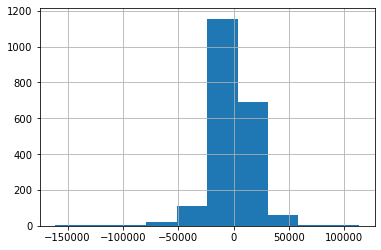

In [18]:
y.hist()

In [19]:
run_model(gs_knn, 'knn')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=uniform; total time=   0.0s
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=uniform; total time=   0.1s
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=uniform; total time=   0.0s
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=uniform; total time=   0.0s
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=uniform; total time=   0.0s
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=distance; total time=   0.0s
[CV] END kneighborsregressor__n_neighbors=2, kneighborsregressor__p=1, kneighborsregressor__weights=distance; total time=   0.0s
[CV] END kneighborsregressor__n_neighbo

In [20]:
gs_knn.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder-1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002846F09FD00>),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(),
                                                  ['Mo Sold', 'Yr Sold',
                                                   'MoYr Sold']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002846F09F070>)],
                                   verbose_feature_

In [22]:
pd.DataFrame(gs_knn.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsregressor__n_neighbors,param_kneighborsregressor__p,param_kneighborsregressor__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,0.047404,0.001854,0.072024,0.001411,14,1,distance,"{'kneighborsregressor__n_neighbors': 14, 'knei...",-0.029998,0.075745,-0.016678,0.027831,0.060616,0.023503,0.041478,1
129,0.062734,0.015730,0.092956,0.013649,34,1,distance,"{'kneighborsregressor__n_neighbors': 34, 'knei...",-0.015152,0.032538,0.008179,0.032358,0.056519,0.022888,0.024402,2
81,0.421933,0.018550,0.788313,0.054758,22,1,distance,"{'kneighborsregressor__n_neighbors': 22, 'knei...",-0.030105,0.059783,-0.008567,0.038338,0.052624,0.022415,0.035442,3
141,0.048528,0.003114,0.079444,0.004214,37,1,distance,"{'kneighborsregressor__n_neighbors': 37, 'knei...",-0.015804,0.029367,0.011233,0.026359,0.060313,0.022294,0.024843,4
69,0.052213,0.003860,0.086947,0.008287,19,1,distance,"{'kneighborsregressor__n_neighbors': 19, 'knei...",-0.042130,0.057491,-0.001396,0.032557,0.063364,0.021977,0.039350,5
